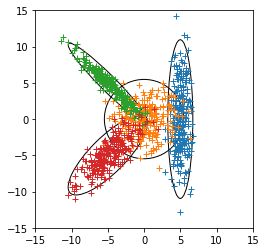

In [650]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

def plot_bivariate_norm(mean, cov, N=250 ,ax = None, fmt = '+', **kwarg):
    """
    Plot a bivariate normal distribution.
    Parameters
    ----------
        mean : the center (x0, y0) of the bivariate normal distributions
        cov  : a 2*2 covariance matrix
        N    : number of 2d points
        ax : The axis that the points will be plotted on. Defaults to the 
            current axis.
        fmt : format of matplotlib plot funciton
        Additional keyword arguments are pass on to the matplotlib plot 
            function.
    Returns
    -------
        a N*2 np.array based on bivaraiate normal distribution
    """
    if ax is None:
        ax = plt.gca()
    
    x, y = np.random.multivariate_normal(mean, cov, N).T  
    plt.plot(x, y, fmt, **kwarg)
    points = np.array(list(zip(x, y)))
    return points

def plot_cov_ellipse(mean, cov, s=5.991, ax=None, **kwargs):
    """
    Plot a covariance error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    see more: 
        http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
    Parameters
    ----------
        mean : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        cov : The 2x2 covariance matrix to base the ellipse on  
        s : The scale of the ellipse, the default is 5.991 as 95% confidence 
            interval.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    # alpha = arctan (vec1(y)/vec1(x)), 
    # where vec1 is the eigenvector of the largest eigenvalue.
    # vec1(y) is the 'y-coordinate'
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(s * vals)
    ellip = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

# Generate the data set and plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')

means = [[5, 0], [0, 0], [-5, 5], [-5, -5]]
covs = [[[0.5, 0], [0, 20]], 
       [[5, 0], [0, 5]], 
       [[5, -4.8], [-4.8, 5]], 
       [[5, 4], [4, 5]]]

data = None
kwrg = {'edgecolor':'k', 'linewidth':1.0, 'facecolor':'None'}
for mean, cov in zip(means, covs):
    points = plot_bivariate_norm(mean, cov, N=250, ax=ax)
    plot_cov_ellipse(mean, cov, s = 5.991, ax=ax, **kwrg)
    if data is None:
        data = points[:]
    else:
        data = np.append(data, points, axis = 0)
    
    
plt.axis([-15, 15, -15, 15], 'equal')
plt.show()

# shuffle the data
# add noise to the center of the ellipse, as input of the means.
np.random.shuffle(data)
means = np.random.rand(4, 2) * 10 + np.array([[5, 0], [0, 0], [-5, 5], [-5, -5]])

In [651]:
import scipy.linalg as linalg
import numpy as np    

class Gaumixmod(object):
    """
    Gaussian mixture model.
    see Numerical Recipes 3rd edition.
    Parameters:
    -----------
        data : n*m data set, where n is number of data
            and m is the dimension of the data, e.g., (n,m) = (1000,2)
        means : K means, K centers of each Gaussians.
            k*m, where k is the number of proposed Gaussians. 
        frac : fraction of data points in the k-th Gaussian.
        sig : K covariance matrices, size is k*m*m. 
        resp : responsibility matrix, n*k. For each data, it represents
            the probablity that the data falls into the k-th Gaussian. 
        lndets : logarithm of the determinant of the covariance matrix.
        loglike : logarithm of the likelihood.         
    """
    def __init__(self, data, means = None, k = 4, n_iter = 15):
        
        self.data = data
        self.n, self.m = data.shape
        self.k = k
        # provide initial means if not given
        if means is None:
            avgs = np.mean(self.data, axis = 0)
            covs = np.var(self.data, axis = 0)
            alp = 0.1
            self.means = np.stack([avgs + covs * np.random.rand(self.m)*alp for _ in range(k)], axis = 0)
        else:
            self.means = means
                
        # initilization of covariance matrix
        self.frac = np.ones(k) * 1.0/k
        self.sig  = np.stack([np.eye(self.m)*1.e-10 for _ in range(self.k)], axis = 0)
        
        # collection of data (means, sigs, loglike) from iterations
        self.allmeans = []
        self.allsigs  = []
        self.allloglike = []
        self.allmeans.append(self.means.copy())
        self.allsigs.append(self.sig.copy())
                
        for _ in range(n_iter):
            self.estep()
            self.mstep()
            self.allmeans.append(self.means.copy())
            self.allsigs.append(self.sig.copy())
        
        
    def estep(self):
        """
        Expectation step.
        """     
        oldloglike = np.finfo('float64').min
        self.resp = np.zeros((self.n, self.k))
        self.lndets = np.zeros(self.k)
        for k in range(self.k):
            L = linalg.cholesky(self.sig[k], True)
            self.lndets[k] = np.log(np.prod(np.diagonal(L))**2)
            for n in range(self.n):
                u = self.data[n] - self.means[k]
                v = linalg.solve_triangular(L, u, lower=True)
                q_sum = np.dot(v,v)
                self.resp[n][k] = -0.5 * (q_sum + self.lndets[k]) + np.log(self.frac[k])
                
        # Use log-sum-exp trick here
        self.loglike = 0.0
        for n in range(self.n):
            lmax = -99.9e99
            for k in range(self.k):
                if self.resp[n][k] > lmax:
                    lmax = self.resp[n][k]
            lsum  = np.sum(np.exp(self.resp[n] - lmax))
            tmp = lmax + np.log(lsum)
            self.resp[n] = np.exp(self.resp[n] - tmp)
            self.loglike += tmp
        
        self.allloglike.append(self.loglike)
        return self.loglike - oldloglike
    
    
    def mstep(self):
        """
        Maximizatoin step
        """
        self.wgt = np.sum(self.resp, axis = 0)
        self.frac = self.wgt / self.n
        
        self.means = np.matmul(self.resp.T, self.data)
        self.means = self.means / self.wgt[:, None]
        
        for k in range(self.k):
            tmp = self.data - self.means[k]
            self.sig[k] = np.zeros((self.m, self.m))
            for n in range(self.n):
                rowtmp = tmp[n].reshape(1, -1)
                sigtmp = np.matmul(rowtmp.T, rowtmp)
                self.sig[k] += sigtmp * self.resp[n][k]
            self.sig[k] /= self.wgt[k]
               
    

In [656]:
mod = Gaumixmod(data, None, 3, 20)
mod.allloglike

[-168658888167906.06,
 -3589.6068516381924,
 -3354.7235926908074,
 -3307.783014499979,
 -3283.8878837102266,
 -3270.783686192538,
 -3263.183914767918,
 -3259.5082890492963,
 -3258.0513336640493,
 -3257.4789084357685,
 -3257.22784845776,
 -3257.1054849374477,
 -3257.0417223505074,
 -3257.007299772732,
 -3256.988408648797,
 -3256.9779740629406,
 -3256.9722010134697,
 -3256.9690085023067,
 -3256.9672452255077,
 -3256.966272696475]

In [637]:
avgs = np.mean(data, axis = 0)
covs = np.var(data, axis = 0)
alp = 1.0
means = np.stack([avgs + covs * np.random.rand(2)*alp for _ in range(4)], axis = 0)

In [638]:
means

array([[13.0888314 ,  5.19383564],
       [ 4.95270667, -0.05319346],
       [ 0.1300957 , 18.8662155 ],
       [17.79639425, 14.51702035]])

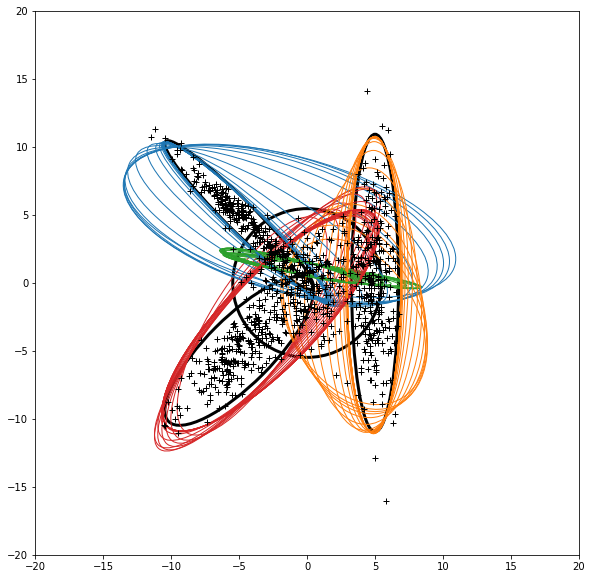

In [653]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

means = [[5, 0], [0, 0], [-5, 5], [-5, -5]]

covs = [[[0.5, 0], [0, 20]], 
       [[5, 0], [0, 5]], 
       [[5, -4.8], [-4.8, 5]], 
       [[5, 4], [4, 5]]]

plt.plot(data[:, 0], data[:, 1], 'k+')

kwrg = {'edgecolor':'k', 'linewidth':3.0, 'facecolor':'None'}
for mean, cov in zip(means, covs):
    plot_cov_ellipse(mean, cov, s = 5.991, ax=ax, **kwrg)
    

for i in range(len(mod.allmeans)):
    poss, covs = mod.allmeans[i], mod.allsigs[i]
    for i in range(len(poss)):
        kwrg = {'edgecolor':'C{0}'.format(i), 'linewidth':1.0, 'facecolor':'None'}
        plot_cov_ellipse(poss[i], covs[i], s = 5.991, ax=ax, **kwrg)
    
    
plt.axis([-20, 20, -20, 20], 'equal')
plt.show()


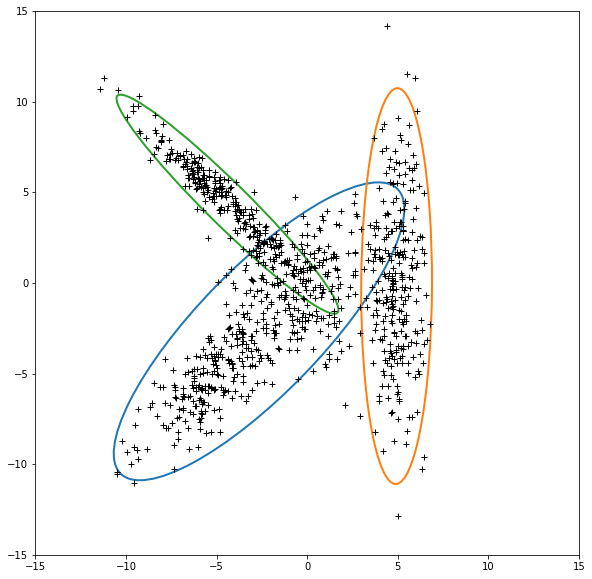

In [657]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

plt.plot(data[:, 0], data[:, 1], 'k+')
    

poss, covs = mod.allmeans[-1], mod.allsigs[-1]
for i in range(len(poss)):
    kwrg = {'edgecolor':'C{0}'.format(i), 'linewidth':2.0, 'facecolor':'None'}
    plot_cov_ellipse(poss[i], covs[i], s = 5.991, ax=ax, **kwrg)
    
    
plt.axis([-15, 15, -15, 15], 'equal')
plt.show()


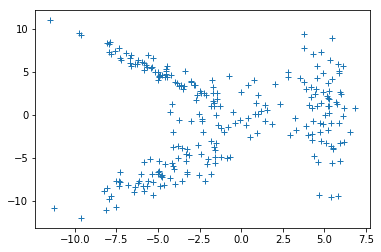

In [219]:
plt.plot(data[:250, 0], data[:250, 1], '+')
plt.show()

In [125]:
from matplotlib.patches import Ellipse
from numpy.linalg import cholesky

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

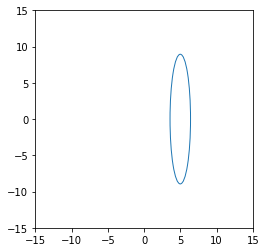

In [165]:
pos = np.array([5, 0])
cov = np.array([[0.5, 0], [0, 20]])
kwargs = {'edgecolor':'C0', 'linewidth':1, 'facecolor':'None'}
plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()

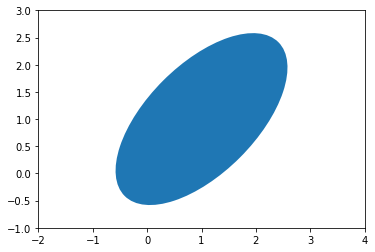

In [146]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

delta = 45.0  # degrees

e = Ellipse((1, 1), 4, 2, delta)

a = plt.subplot(111, aspect='equal')


#e.set_clip_box(a.bbox)
#e.set_alpha(0.1)
a.add_artist(e)

plt.xlim(-2, 4)
plt.ylim(-1, 3)

plt.show()

In [120]:
plt.show()

In [132]:
width, height, theta

(7.800282700243108, 1.7763979836422032, 61.8450337629899)